# Information

- Ho Ten: Ngo Ngoc Ha Khanh

- MSSV: 21280019

# Process Data

I choose Mnist dataset for lab 01.

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

100%|████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5833566.43it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 30110786.43it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 6667545.34it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
print(len(mnist_trainset))
print(len(mnist_testset))
print(mnist_trainset.data.shape)
print(mnist_testset.data.shape)

60000
10000
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


The reshaping of images into a 3D tensor is crucial for preparing the data for Convolutional Neural Network (CNN) training. The (28, 28, 1) shape signifies that each image has a height of 28 pixels, a width of 28 pixels, and a single channel representing grayscale intensity.

In [5]:
mnist_trainset.data = mnist_trainset.data.view(-1, 1, 28, 28)
mnist_testset.data = mnist_testset.data.view(-1, 1, 28, 28)
print(mnist_trainset.data.shape)
print(mnist_testset.data.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


Normalizing the data to help with the training

In [6]:
mnist_trainset.data = mnist_trainset.data.float() / 255.0
mnist_testset.data = mnist_testset.data.float() / 255.0

# Data Augmentation

I will randomly choose 10000 images to transform. There are three transformations: blur, adjust image brightness and rotate image.

In [7]:
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

num_images_to_augment = 10000

random_indices = torch.randperm(len(mnist_trainset))[:num_images_to_augment]

data_transform1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.ToTensor()
])

data_transform2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor()
])

data_transform3 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=1.8, contrast=1.0, saturation=1.0, hue=0.0),
    transforms.ToTensor()
])

augmented_images = []
augmented_labels = []

for index in random_indices:
    img = mnist_trainset.data[index]
    label = mnist_trainset.targets[index]

    augmented_img1 = data_transform1(img)
    augmented_img2 = data_transform2(img)
    augmented_img3 = data_transform3(img)

    augmented_images.append(augmented_img1)
    augmented_images.append(augmented_img2)
    augmented_images.append(augmented_img3)

    augmented_labels.append(label)
    augmented_labels.append(label)
    augmented_labels.append(label)

augmented_images_stack = torch.stack(augmented_images)
mnist_trainset.data = torch.cat([mnist_trainset.data, augmented_images_stack])
mnist_trainset.targets = torch.cat([mnist_trainset.targets, torch.tensor(augmented_labels)])

In [8]:
print("Train_images shape", mnist_trainset.data.shape)
print("Train_labels shape", mnist_trainset.targets.shape)

Train_images shape torch.Size([90000, 1, 28, 28])
Train_labels shape torch.Size([90000])


# Build CNN Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        self.pool = nn.MaxPool2d(kernel_size=(1, 1))
        self.fc1 = nn.Linear(25 * 26 * 26, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 25 * 26 * 26)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Khởi tạo mô hình PyTorch
model1_pytorch = Model1()
model1_pytorch.to(device)

# In ra kiến trúc của mô hình
print(model1_pytorch)


Model1(
  (conv1): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16900, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [10]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 32 * 13 * 13)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Khởi tạo mô hình
model2_pytorch = Model2()
model2_pytorch.to(device)
print(model2_pytorch)

Model2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Training Model

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

mnist_trainset_tensor = torch.tensor(mnist_trainset.data, dtype=torch.float32)
mnist_trainset_labels_tensor = torch.tensor(mnist_trainset.targets, dtype=torch.long)

mnist_trainset_tensor, mnist_valset_tensor, mnist_trainset_labels_tensor, mnist_valset_labels_tensor = train_test_split(
    mnist_trainset_tensor, mnist_trainset_labels_tensor, test_size=0.2, random_state=42
)

# Tạo DataLoader cho tập huấn luyện và tập validation
mnist_trainset_dataset = TensorDataset(mnist_trainset_tensor, mnist_trainset_labels_tensor)
mnist_valset_dataset = TensorDataset(mnist_valset_tensor, mnist_valset_labels_tensor)

mnist_trainset_loader = DataLoader(mnist_trainset_dataset, batch_size=128, shuffle=True)
mnist_valset_loader = DataLoader(mnist_valset_dataset, batch_size=128, shuffle=False)

# Đánh giá mô hình trên tập test
mnist_testset_tensor = torch.tensor(mnist_testset.data, dtype=torch.float32)
mnist_testset_labels_tensor = torch.tensor(mnist_testset.targets, dtype=torch.long)
mnist_testset_dataset = TensorDataset(mnist_testset_tensor, mnist_testset_labels_tensor)
mnist_testset_loader = DataLoader(mnist_testset_dataset, batch_size=128)


mnist_trainset_tensor = mnist_trainset_tensor.to(device)
mnist_trainset_labels_tensor = mnist_trainset_labels_tensor.to(device)
mnist_valset_tensor = mnist_valset_tensor.to(device)
mnist_valset_labels_tensor = mnist_valset_labels_tensor.to(device)
mnist_testset_tensor = mnist_testset_tensor.to(device)
mnist_testset_labels_tensor = mnist_testset_labels_tensor.to(device)


C:\Users\MODERN\AppData\Local\Temp\ipykernel_15456\1108784575.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mnist_trainset_tensor = torch.tensor(mnist_trainset.data, dtype=torch.float32)
C:\Users\MODERN\AppData\Local\Temp\ipykernel_15456\1108784575.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mnist_trainset_labels_tensor = torch.tensor(mnist_trainset.targets, dtype=torch.long)
C:\Users\MODERN\AppData\Local\Temp\ipykernel_15456\1108784575.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mnist_testset_tensor = torch.tensor(

In [12]:
optimizer = optim.Adam(model1_pytorch.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Huấn luyện mô hình
num_epochs = 20
for epoch in range(num_epochs):
    model1_pytorch.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in mnist_trainset_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model1_pytorch(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    average_train_loss = train_loss / len(mnist_trainset_loader)
    train_accuracy = 100 * correct_train / total_train

    model1_pytorch.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for images, labels in mnist_valset_loader:
            outputs = model1_pytorch(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()

    average_val_loss = val_loss / len(mnist_valset_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

model1_pytorch.eval()
with torch.no_grad():
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    for images, labels in mnist_testset_loader:
        outputs = model1_pytorch(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted_test = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted_test.eq(labels).sum().item()

test_accuracy = 100 * correct_test / total_test

print(f'Test Loss: {test_loss / len(mnist_testset_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/20, Train Loss: 1.7345, Train Accuracy: 79.51%, Val Loss: 1.6034, Val Accuracy: 88.57%
Epoch 2/20, Train Loss: 1.5829, Train Accuracy: 89.79%, Val Loss: 1.5682, Val Accuracy: 91.04%
Epoch 3/20, Train Loss: 1.5609, Train Accuracy: 91.44%, Val Loss: 1.5557, Val Accuracy: 91.80%
Epoch 4/20, Train Loss: 1.5490, Train Accuracy: 92.42%, Val Loss: 1.5446, Val Accuracy: 92.73%
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\MODERN\AppData\Local\Temp\ipykernel_15456\565872850.py", line 18, in <module>
    optimizer.step()
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\optimizer.py", line 280, in wrapper
    out = func(*args, **kwargs)
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\optimizer.py", line 33, in _use_grad
    ret = func(self, *args, **kwargs)
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\adam.py", line 141, in step
    adam(
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\adam.py", line 281, in adam
    func(params,
  File "C:\Users\MODERN\AppData\Local\Programs\Python

In [13]:
optimizer = optim.Adam(model2_pytorch.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Huấn luyện mô hình
num_epochs = 20
for epoch in range(num_epochs):
    model2_pytorch.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in mnist_trainset_loader:
        optimizer.zero_grad()
        outputs = model2_pytorch(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    average_train_loss = train_loss / len(mnist_trainset_loader)
    train_accuracy = 100 * correct_train / total_train

    model2_pytorch.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for images, labels in mnist_valset_loader:
            outputs = model2_pytorch(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()

    average_val_loss = val_loss / len(mnist_valset_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

model2_pytorch.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for images, labels in mnist_testset_loader:
        outputs = model2_pytorch(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Loss: {test_loss/len(mnist_testset_loader)}, Test Accuracy: {100*correct/total}%')


Epoch 1/20, Train Loss: 0.3401, Train Accuracy: 90.25%, Val Loss: 0.1665, Val Accuracy: 95.29%
Epoch 2/20, Train Loss: 0.1496, Train Accuracy: 95.76%, Val Loss: 0.1166, Val Accuracy: 96.85%
Epoch 3/20, Train Loss: 0.1092, Train Accuracy: 96.90%, Val Loss: 0.0996, Val Accuracy: 97.23%
Epoch 4/20, Train Loss: 0.0897, Train Accuracy: 97.47%, Val Loss: 0.0836, Val Accuracy: 97.72%
Epoch 5/20, Train Loss: 0.0742, Train Accuracy: 97.85%, Val Loss: 0.0782, Val Accuracy: 97.91%
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\MODERN\AppData\Local\Temp\ipykernel_15456\3075312286.py", line 15, in <module>
    outputs = model2_pytorch(images)
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\MODERN\AppData\Local\Temp\ipykernel_15456\3670217842.py", line 12, in forward
    x = self.pool(x)
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\MODERN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\pooling.py", line 166, in forward
    return F.max_pool2d(input, self

313/313 [==============================] - 4s 12ms/step


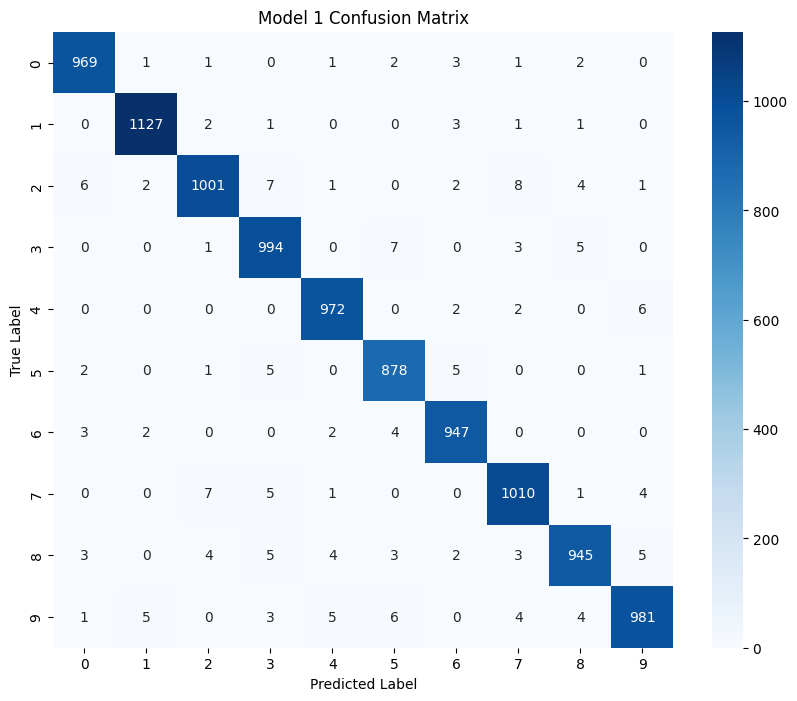

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

# Predict probabilities for the test data
predicted_probabilities = model1.predict(test_images)

# Choose the class with the highest probability as the predicted label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Get unique labels to ensure the correct order on the confusion matrix
classes = unique_labels(test_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Model 1 Confusion Matrix')
plt.show()


313/313 [==============================] - 3s 9ms/step


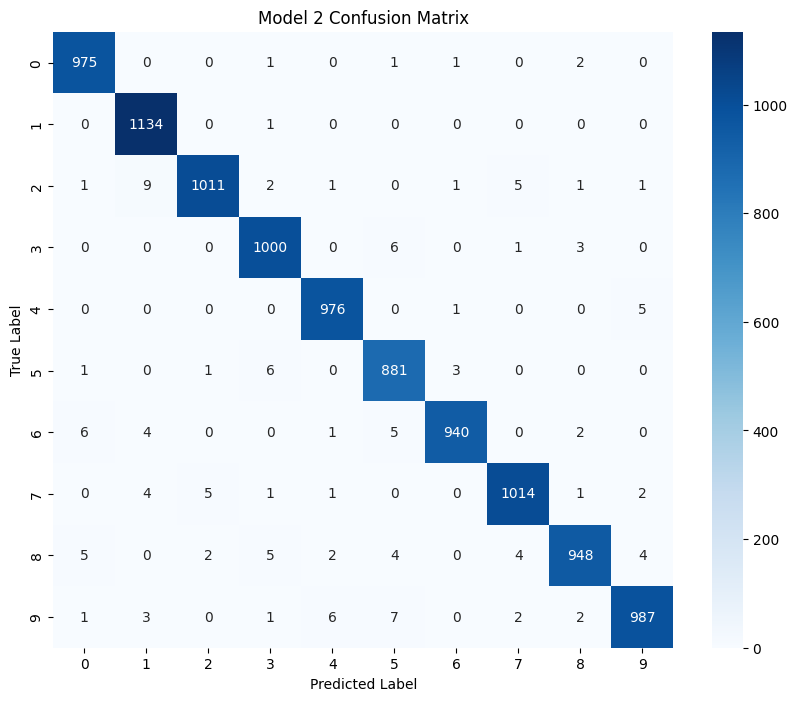

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

# Predict probabilities for the test data
predicted_probabilities = model2.predict(test_images)

# Choose the class with the highest probability as the predicted label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Get unique labels to ensure the correct order on the confusion matrix
classes = unique_labels(test_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Model 2 Confusion Matrix')
plt.show()


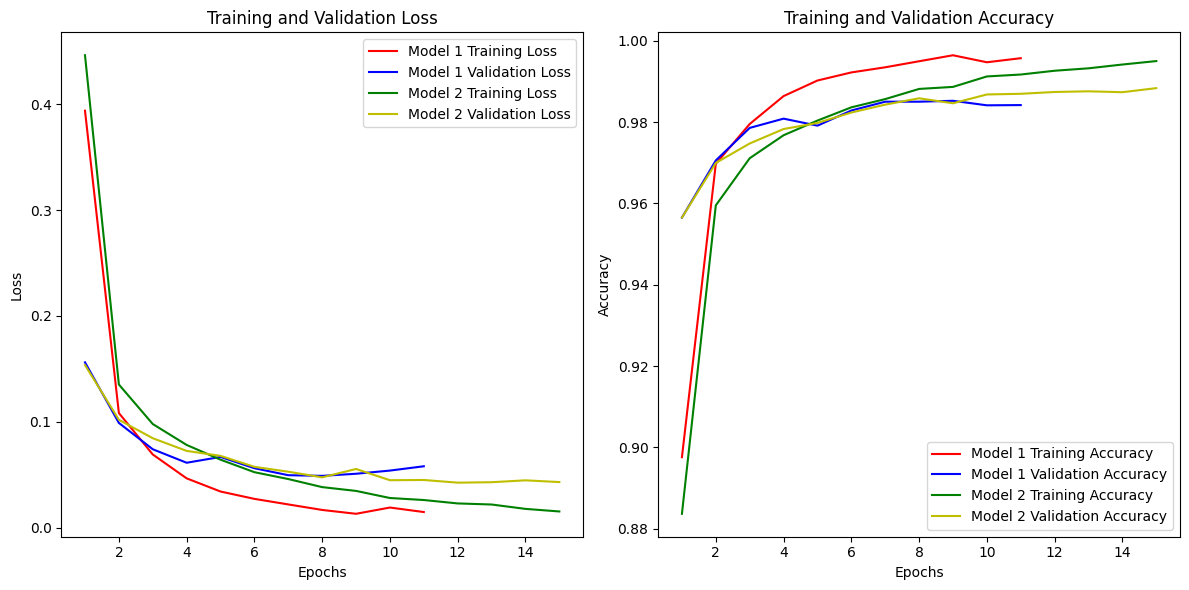

In [ ]:
import matplotlib.pyplot as plt

# Get information about loss and accuracy from the 'history' variable of model1
train_loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
train_acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
epochs1 = range(1, len(train_loss1) + 1)

# Get information about loss and accuracy from the 'history' variable of model2
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
train_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
epochs2 = range(1, len(train_loss2) + 1)

# Plot the graphs
plt.figure(figsize=(12, 6))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_loss1, 'r', label='Model 1 Training Loss')
plt.plot(epochs1, val_loss1, 'b', label='Model 1 Validation Loss')
plt.plot(epochs2, train_loss2, 'g', label='Model 2 Training Loss')
plt.plot(epochs2, val_loss2, 'y', label='Model 2 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs1, train_acc1, 'r', label='Model 1 Training Accuracy')
plt.plot(epochs1, val_acc1, 'b', label='Model 1 Validation Accuracy')
plt.plot(epochs2, train_acc2, 'g', label='Model 2 Training Accuracy')
plt.plot(epochs2, val_acc2, 'y', label='Model 2 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


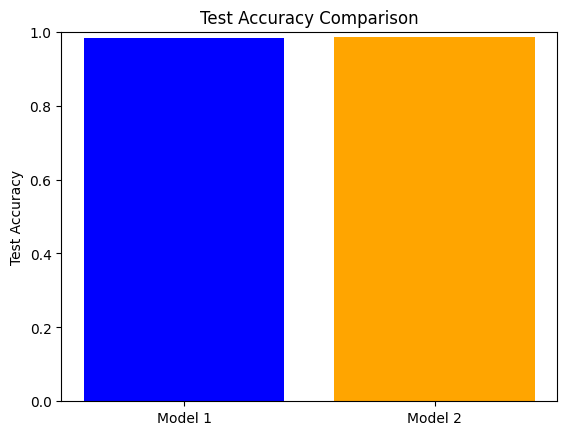

In [ ]:
# Get test accuracy for Model 1
test_loss_model1, test_acc_model1 = model1.evaluate(test_images, test_labels, verbose=0)

# Get test accuracy for Model 2
test_loss_model2, test_acc_model2 = model2.evaluate(test_images, test_labels, verbose=0)

# Create a bar graph to compare test accuracies
models = ['Model 1', 'Model 2']
test_accuracies = [test_acc_model1, test_acc_model2]

plt.bar(models, test_accuracies, color=['blue', 'orange'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)  # Set the y-axis limit to the range of accuracy (0 to 1)
plt.show()

# Hyperparameter Tuning

In the comparison of the two models, Model 1, despite having fewer filters and layers, outperforms Model 2. This finding suggests that, when dealing with the **MNIST dataset**, there is **no necessity** to employ a **complex architecture**.

In [ ]:
from keras.optimizers import Adam
# Define the learning rates to be tested
learning_rates = [0.001, 0.01, 0.1]

# Store the history of each model for plotting
histories = []

# Iterate over each learning rate
for lr in learning_rates:
    model2_lr = Sequential()
    model2_lr.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model2_lr.add(MaxPool2D(pool_size=(2, 2)))

    model2_lr.add(Dropout(0.2))

    model2_lr.add(Flatten())

    model2_lr.add(Dense(128, activation='relu'))
    model2_lr.add(Dense(10, activation='softmax'))
    # Compile the model with the given learning rate
    optimizer = Adam(learning_rate=lr)
    model2_lr.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and store the history
    history_lr = model2_lr.fit(train_images, train_labels, batch_size=128, epochs=10,
                        validation_data=(val_images, val_labels), callbacks=[early_stopping], verbose=0)

    histories.append(history_lr)

# Plot the training and validation accuracy for each learning rate
plt.figure(figsize=(12, 8))
for i, history_lr in enumerate(histories):
    plt.plot(history_lr.history['accuracy'], label=f'Training Rate: {learning_rates[i]}')
    plt.plot(history_lr.history['val_accuracy'], label=f'Validation Rate: {learning_rates[i]}', linestyle='dashed')

plt.title('Training and Validation Accuracy for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyboardInterrupt: ignored

After running the model with different learning rates, it was observed that a learning rate of 0.001 yielded the best results. This suggests that, among the tested learning rates, 0.001 is the most effective for optimizing the model's performance on the given task.

In [ ]:
# Define the batch sizes to be tested
batch_sizes = [64, 128, 256]

# Store the history of each model for plotting
histories = []

# Iterate over each batch size
for bs in batch_sizes:
    # Compile the model with the given batch size
    model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and store the history
    history_bs = model2.fit(train_images, train_labels, batch_size=bs, epochs=15,
                        validation_data=(val_images, val_labels), callbacks=[early_stopping], verbose=0)

    histories.append(history_bs)

# Plot the training and validation accuracy for each batch size
plt.figure(figsize=(12, 8))
for i, history_bs in enumerate(histories):
    plt.plot(history_bs.history['accuracy'], label=f'Training Batch Size: {batch_sizes[i]}')
    plt.plot(history_bs.history['val_accuracy'], label=f'Validation Batch Size: {batch_sizes[i]}', linestyle='dashed')

plt.title('Training and Validation Accuracy for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Summary